# Goals
With the sample dataset from Parkway Pantai, create a predictive model that can accurately classify individuals as either __having__ or __not having__ heart disease.<br><br>
In this notebook, I will be having an initial glance of the data and cleaning it accordingly.<br>
Relationship analysis and modelling will be done in the next notebook.
<br><br>
_Dataset was provided by NTUC Learning Hub as part of the SCTP Data Analyst Course Capstone Project_<br>
_Additionally, this resembles the [Cardiovascular Disease dataset](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset) on kaggle._
***

# Contents
- [Libraries](#s1)
- [Data](#s2)
    - [Import Data](#s3)
    - [Exploring the Data](#s4)
    - [Initial Findings](#s5)
    - [Cleaning](#s6)
        - [ID](#s7)
        - [Age](#s8)
        - [Active, Smoke & Disease](#s9)
        - [Cholesterol & gluc](#s10)
        - [Weight, Height, ap_hi & ap_lo](#s11)
            - [Weight & Height](#s12)
            - [ap_hi & ap_lo](#s13)
        - [String columns](#s14)
            - [Country](#s15)
            - [Occupation](#s16)
        - [Date](#s17)
    - [Final Touch-up](#s18)
    - [Export data](#s19)



# Libraries <a id="s1"></a>
Let's first import what we think is the required libraries for this project

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import sqlalchemy
from sqlalchemy import text
from sqlalchemy import select
from decouple import config


# Data<a id="s2"></a>

## Import Data<a id="s3"></a>

I had uploaded the data into Postgresql server.<br>
Using `sqlalchemy`, established a connection with the local database in Postgresql to be able to use the data in this notebook

In [2]:
url = config("url")
engine = sqlalchemy.create_engine(url)

Create dataframe with pandas

In [3]:
from sqlalchemy.sql import text
sql = '''
    SELECT * FROM cardio_data;
'''
with engine.connect() as conn:
    query = conn.execute(text(sql))         
og_df = pd.DataFrame(query.fetchall())

Make a backup copy of the data in the variable og_df. <br>
Will be useful at the end for any statiscal information.

In [4]:
df = og_df 

## Exploring the Data <a id="s4"></a>

Let's see how the data looks like at a glance.

In [5]:
df.head(10)

,date,country,id,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,occupation,smoke,weight,disease
0,2021-05-03,Indonesia,0,1,18393,0,110,80,1,2,1,168,Architect,0,62.00,0
1,2021-08-05,Malaysia,1,1,20228,0,140,90,3,1,1,156,Accountant,0,85.00,1
2,2022-11-13,Indonesia,2,0,18857,0,130,70,3,1,1,165,Chef,0,64.00,1
3,2018-10-31,Singapore,3,1,17623,0,150,100,1,2,1,169,Lawyer,0,82.00,1
4,2020-09-25,Singapore,4,0,17474,0,100,60,1,1,1,156,Architect,0,56.00,0
5,2021-12-21,Indonesia,8,0,21914,0,120,80,2,1,2,151,Teacher,0,67.00,0
6,2021-01-08,Malaysia,9,1,22113,0,130,80,3,1,1,157,Architect,0,93.00,0
7,2022-08-19,Malaysia,12,1,22584,0,130,90,3,2,3,178,Chef,0,95.00,1
8,2020-11-09,India,13,1,17668,0,110,70,1,1,1,158,Lawyer,0,71.00,0
9,2022-04-28,Malaysia,14,0,19834,0,110,60,1,1,1,164,Accountant,0,68.00,0


Let's check what kind of data we have and if there are any nulls

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         70000 non-null  object
 1   country      70000 non-null  object
 2   id           70000 non-null  int64 
 3   active       70000 non-null  int64 
 4   age          70000 non-null  int64 
 5   alco         70000 non-null  int64 
 6   ap_hi        70000 non-null  int64 
 7   ap_lo        70000 non-null  int64 
 8   cholesterol  70000 non-null  int64 
 9   gender       70000 non-null  object
 10  gluc         70000 non-null  int64 
 11  height       70000 non-null  int64 
 12  occupation   70000 non-null  object
 13  smoke        70000 non-null  int64 
 14  weight       70000 non-null  object
 15  disease      70000 non-null  int64 
dtypes: int64(11), object(5)
memory usage: 8.5+ MB


All columns have the same number of entries, so there are no nulls. <br>
We can check with the `.isnull()` method to reconfirm

In [7]:
df.isnull().sum()

date           0
country        0
id             0
active         0
age            0
alco           0
ap_hi          0
ap_lo          0
cholesterol    0
gender         0
gluc           0
height         0
occupation     0
smoke          0
weight         0
disease        0
dtype: int64

All rows returned 0, thus reconfirming that there are no nulls.<br>
Check for duplications

In [8]:
df.duplicated().sum()

0

No duplications found. <br>
We can look at the number of entries to give us an idea of what each column can tell us

In [9]:
df.nunique()

date            1827
country            4
id             70000
active             2
age             8076
alco               2
ap_hi            153
ap_lo            157
cholesterol        3
gender             2
gluc               3
height           109
occupation         9
smoke              2
weight           287
disease            2
dtype: int64

## Initial Findings<a id="s5"></a>

The data contain the following information and with the following assumptions:<br>


| Column | Data Type | Data Description |
| :-: | :-: | :- |
| date | object | date field of unknown |
| country | object | country of origin for the patient |
| id | int64 | Key for each patient in the data |
| active | int64 | If the patient is active. 0 for no, 1 for yes |
| age | int64 | Age of the patient |
| alco | int64 | If the patient consumes alcohol. 0 for no, 1 for yes |
| ap_hi | int64 | Systolic Blood pressure |
| ap_lo | int64 | Diastolic Blood pressure |
| cholesterol | int64 | Cholesterol level of patient. 1 for normal, 2 for borderline and 3 for high |
| gender | object | Gender of patient. Unknown what 1 and 2 means. |
| gluc | int64 | Blood glucose level of patient. 1 for normal, 2 for prediabetic and 3 for diabetic |
| height | int64 | Height of patient |
| occupation | object | Occupatient of patient |
| smoke | int64 | If the patient smokes. 0 for no, 1 for yes|
| weight | object | Weight of patient |
| disease | int64 | Presence of cardiovascular disease. 0 for no, 1 for yes |


- There do not seem to be any null values or duplicates in any of the columns
- Age seems to be a weird number (this might be in days?)
- Assumption that __id__ column acts as a primary key, need to confirm if there are _no_ duplicates. Will keep this column until the end before dropping.
- Columns __active__, __smoke__ and __disease__ seem to be in a numeric boolean format
- Columns __cholestrol__ and __gluc__ seem to be numerical categories
- __weight__ is an object dtype, should be int or float. 
- Check if __weight__, __height__, __ap_hi__ and __ap_lo__ have illogical values or outliers
- Confirm how many categories __gender__ has
- Need to convert all columns to boolean numerical catergoricals<br><br>

<div class="alert alert-block alert-info">
In the rest of the notebook and subsequent notebooks, cardiovascular disease will be referred by the abbreviation cvd.</div>

## Cleaning Data<a id="s6"></a>
### ID Column<a id="s7"></a>
Check if ID column has duplicate values

In [10]:
dfindex_dup = df['id'].duplicated()

In [11]:
dfindex_dup.value_counts()

False    70000
Name: id, dtype: int64

There are no 'Trues' in the value counts, all values turn up a 'False'. There are thus no duplicates in the ID column. <br>
Will be using this column as a guide for us to do data cleaning by setting it as a key<br>
As it will not be required for predictive analysis, I will drop this column at the end.

In [12]:
df.set_index('id',inplace=True)
df.head()

,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,occupation,smoke,weight,disease
id,,,,,,,,,,,,,,,
0,2021-05-03,Indonesia,1,18393,0,110,80,1,2,1,168,Architect,0,62.00,0
1,2021-08-05,Malaysia,1,20228,0,140,90,3,1,1,156,Accountant,0,85.00,1
2,2022-11-13,Indonesia,0,18857,0,130,70,3,1,1,165,Chef,0,64.00,1
3,2018-10-31,Singapore,1,17623,0,150,100,1,2,1,169,Lawyer,0,82.00,1
4,2020-09-25,Singapore,0,17474,0,100,60,1,1,1,156,Architect,0,56.00,0


### Age Column<a id="s8"></a>
I am taking the age column and dividing by 365. <br>
As I do not require any decimal points since this is referring to age, used the pandas `.floordiv()` method to give us an int.

In [13]:
df['age']=df['age'].floordiv(365).astype(int)

In [14]:
df.head(10)

,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,occupation,smoke,weight,disease
id,,,,,,,,,,,,,,,
0,2021-05-03,Indonesia,1,50,0,110,80,1,2,1,168,Architect,0,62.00,0
1,2021-08-05,Malaysia,1,55,0,140,90,3,1,1,156,Accountant,0,85.00,1
2,2022-11-13,Indonesia,0,51,0,130,70,3,1,1,165,Chef,0,64.00,1
3,2018-10-31,Singapore,1,48,0,150,100,1,2,1,169,Lawyer,0,82.00,1
4,2020-09-25,Singapore,0,47,0,100,60,1,1,1,156,Architect,0,56.00,0
8,2021-12-21,Indonesia,0,60,0,120,80,2,1,2,151,Teacher,0,67.00,0
9,2021-01-08,Malaysia,1,60,0,130,80,3,1,1,157,Architect,0,93.00,0
12,2022-08-19,Malaysia,1,61,0,130,90,3,2,3,178,Chef,0,95.00,1
13,2020-11-09,India,1,48,0,110,70,1,1,1,158,Lawyer,0,71.00,0


In [15]:
df['age'].describe()

count    70000.000000
mean        52.840671
std          6.766774
min         29.000000
25%         48.000000
50%         53.000000
75%         58.000000
max         64.000000
Name: age, dtype: float64

The numbers now look like they are represented in years.<br>
We can also glean that the youngest person in this dataset is 29 years old, and the oldest is 64 years old.<br>
And interestingly the mean is around 52 years old, so the data must be skewed to the older end of the age group.<br>
<br>
Let's plot this

Text(0.5, 1.0, 'Data Distribution in Age')

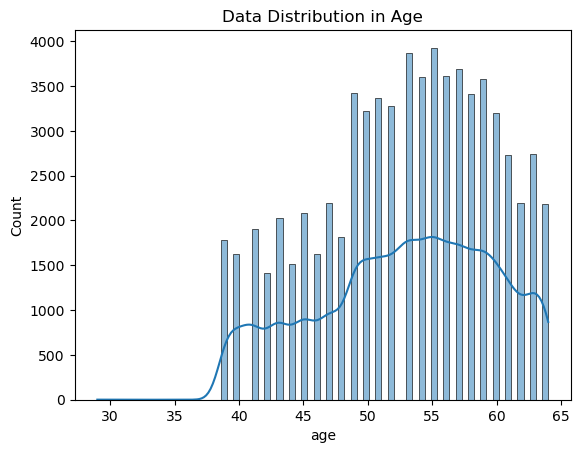

In [16]:
sns.histplot(x=df['age'], kde=True)
plt.title("Data Distribution in Age")

### Active, Smoke & Disease columns <a id="s9"></a>
Let's confirm if  Active, Smoke and Disease are numerical booleans
<br>
Check the unique entries for each of these columns

In [17]:
print('Unique values for active column:',df['active'].unique())
print('Unique values for smoke column:',df['smoke'].unique())
print('Unique values for disease column:',df['disease'].unique())

Unique values for active column: [1 0]
Unique values for smoke column: [0 1]
Unique values for disease column: [0 1]


As for all 3 columns, the only unique values are __0__ and __1__, assumption is that this represents a boolean. We will assume Server Boolean logic here where __0__ represents false and __1__ is true. <br>
<br>
Will keep these columns as is.

### Cholesterol & Gluc columns <a id="s10"></a>
Let's confirm if cholesterol and gluc are categorical numerals

In [18]:
print('Unique values for cholesterol column:',df['cholesterol'].unique())
print('Unique values for gluc column:',df['gluc'].unique())

Unique values for cholesterol column: [1 3 2]
Unique values for gluc column: [1 2 3]


Both columns contain the following unique values: __1__, __2__ and __3__<br>
We will assume that 
- 1 represents __Low__
- 2 represents __Medium__
- 3 represents __High__

Let's just have a quick view of the distribution of the data

Text(0.5, 1.0, 'Distribution of data in gluc')

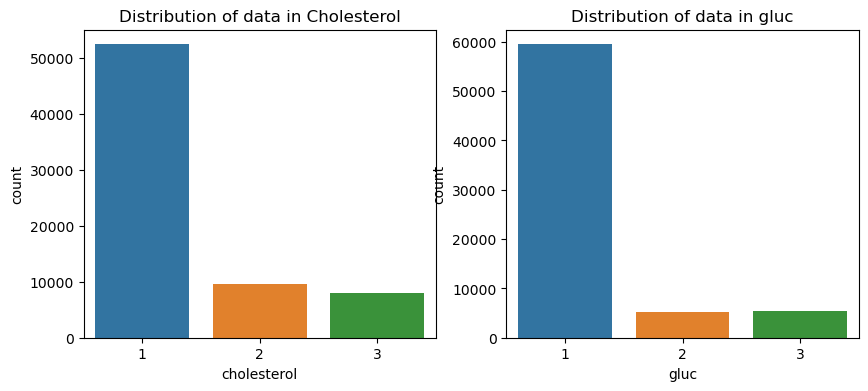

In [19]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.countplot(x=df['cholesterol'])
plt.title('Distribution of data in Cholesterol')

plt.subplot(1,2,2)
sns.countplot(x=df['gluc'])
plt.title('Distribution of data in gluc')

### Weight, height, ap_hi and ap_lo columns <a id="s11"></a>

First let's convert weight column to numeric

In [20]:
df['weight']=df['weight'].astype(int)

In [21]:
df['weight'].info()

<class 'pandas.core.series.Series'>
Int64Index: 70000 entries, 0 to 99999
Series name: weight
Non-Null Count  Dtype
--------------  -----
70000 non-null  int32
dtypes: int32(1)
memory usage: 820.3 KB


Check if weight, height, ap_hi and ap_lo have illogical values

In [22]:
df[['weight','height','ap_hi','ap_lo']].describe()

,weight,height,ap_hi,ap_lo
count,70000.000000,70000.000000,70000.000000,70000.000000
mean,74.204329,164.359229,128.817286,96.630414
std,14.395953,8.210126,154.011419,188.472530
min,10.000000,55.000000,-150.000000,-70.000000
25%,65.000000,159.000000,120.000000,80.000000
50%,72.000000,165.000000,120.000000,80.000000
75%,82.000000,170.000000,140.000000,90.000000
max,200.000000,250.000000,16020.000000,11000.000000


Height and Weight have a large range that seems out of normal population <br><br>
ap_hi and ap_lo have a few issues:
- negative values which is not possible
- max values are way over measurable levels<br><br>
Have an initial view of the data and it's outliers using a box plot.


Text(0.5, 1.0, 'AP_LO data distribution')

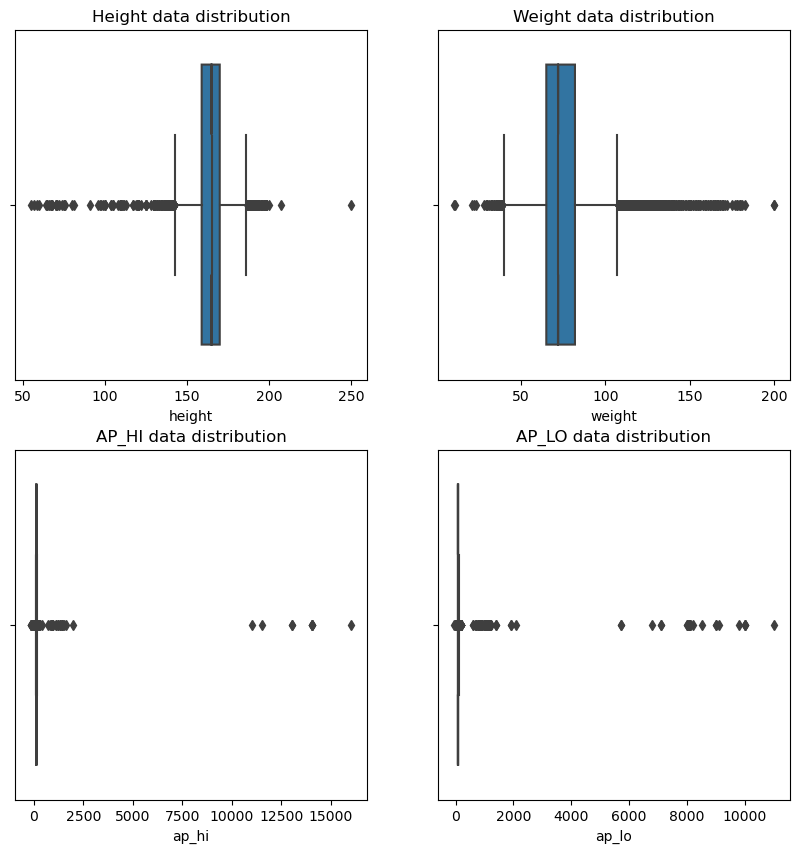

In [23]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
sns.boxplot(data=df,x='height',notch=True)
plt.title("Height data distribution")

plt.subplot(2,2,2)
sns.boxplot(data=df,x='weight',notch=True)
plt.title("Weight data distribution")

plt.subplot(2,2,3)
sns.boxplot(data=df,x='ap_hi',notch=True)
plt.title("AP_HI data distribution")

plt.subplot(2,2,4)
sns.boxplot(data=df,x='ap_lo',notch=True)
plt.title("AP_LO data distribution")

These 4 columns have data quality issues and will be cleaned up in the subsequent steps.

__Weight and Height columns__ <a id="s12"></a><br>
Earlier in [Age](#s8), we established that the whole dataset only have entries from Adults and not children<br>
With this in mind, let's proceed.<br><br>
First lets sort the data in weight, height and age, and have a look<br>


In [24]:
df[['height','weight']].sort_values(by=['weight'],ascending=True).head(20)

,height,weight
id,,
82567,165,10
48318,178,11
85931,162,21
42156,177,22
38312,157,23
48976,128,28
86650,171,29
26503,160,30
5306,120,30


Some of the lower weights do correspond to lower heights, but there are some weights such as in ID 48318 where the height is 178 and the weight is 11.

In [25]:
df[['height','weight']].sort_values(by=['weight'],ascending=False).head(20)

,height,weight
id,,
71945,180,200
618,186,200
87498,180,183
52564,161,181
86506,180,180
6716,176,180
87612,196,180
64829,190,180
28683,165,178


There are some strange height values that have high weight values.<br><br>
Let's combine the height and weight data to give us BMI data instead<br>
So instead of working on 2 columns seperately, we will only need to work on cleaning 1 column

In [26]:
def bmi(height,weight):
    return round((weight/((height/100)**2)),2)

In [27]:
df['bmi'] = bmi(df['height'],df['weight'])
df.head()

,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,occupation,smoke,weight,disease,bmi
id,,,,,,,,,,,,,,,,
0,2021-05-03,Indonesia,1,50,0,110,80,1,2,1,168,Architect,0,62,0,21.97
1,2021-08-05,Malaysia,1,55,0,140,90,3,1,1,156,Accountant,0,85,1,34.93
2,2022-11-13,Indonesia,0,51,0,130,70,3,1,1,165,Chef,0,64,1,23.51
3,2018-10-31,Singapore,1,48,0,150,100,1,2,1,169,Lawyer,0,82,1,28.71
4,2020-09-25,Singapore,0,47,0,100,60,1,1,1,156,Architect,0,56,0,23.01


Based on https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmi_tbl.htm
<br> I shall assume logical BMI range is from 18.5 to 54.

In [28]:
m_normBMI = (df['bmi']>18.49) & (df['bmi']<54.1)

df[m_normBMI].describe()

,active,age,alco,ap_hi,ap_lo,cholesterol,gluc,height,smoke,weight,disease,bmi
count,69209.000000,69209.000000,69209.000000,69209.000000,69209.000000,69209.000000,69209.000000,69209.000000,69209.000000,69209.000000,69209.000000,69209.000000
mean,0.803407,52.860784,0.053808,128.917222,96.764438,1.368247,1.227326,164.425653,0.087994,74.363450,0.501582,27.539033
std,0.397425,6.757311,0.225640,154.819911,189.297894,0.681391,0.573372,7.857782,0.283289,13.956382,0.500001,5.071782
min,0.000000,29.000000,0.000000,-150.000000,-70.000000,1.000000,1.000000,98.000000,0.000000,30.000000,0.000000,18.500000
25%,1.000000,48.000000,0.000000,120.000000,80.000000,1.000000,1.000000,159.000000,0.000000,65.000000,0.000000,23.880000
50%,1.000000,53.000000,0.000000,120.000000,80.000000,1.000000,1.000000,165.000000,0.000000,72.000000,1.000000,26.440000
75%,1.000000,58.000000,0.000000,140.000000,90.000000,2.000000,1.000000,170.000000,0.000000,82.000000,1.000000,30.260000
max,1.000000,64.000000,1.000000,16020.000000,11000.000000,3.000000,3.000000,200.000000,1.000000,180.000000,1.000000,54.010000


The data looks good, will go ahead and commit the mask to the main dataframe.

In [29]:
df = df[m_normBMI]
df.head()

,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,occupation,smoke,weight,disease,bmi
id,,,,,,,,,,,,,,,,
0,2021-05-03,Indonesia,1,50,0,110,80,1,2,1,168,Architect,0,62,0,21.97
1,2021-08-05,Malaysia,1,55,0,140,90,3,1,1,156,Accountant,0,85,1,34.93
2,2022-11-13,Indonesia,0,51,0,130,70,3,1,1,165,Chef,0,64,1,23.51
3,2018-10-31,Singapore,1,48,0,150,100,1,2,1,169,Lawyer,0,82,1,28.71
4,2020-09-25,Singapore,0,47,0,100,60,1,1,1,156,Architect,0,56,0,23.01


Let's check BMI distribution

Let's see how the BMI distribution with weight and height look like

Text(0.5, 1.0, 'BMI data distribution')

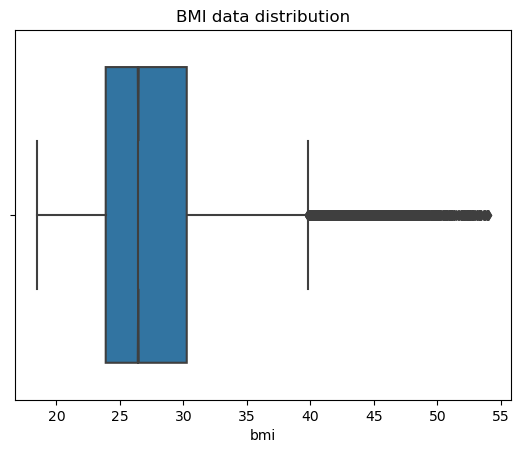

In [30]:
sns.boxplot(data=df,x='bmi',notch=True)
plt.title("BMI data distribution")

Text(0.5, 1.0, 'BMI vs Weight')

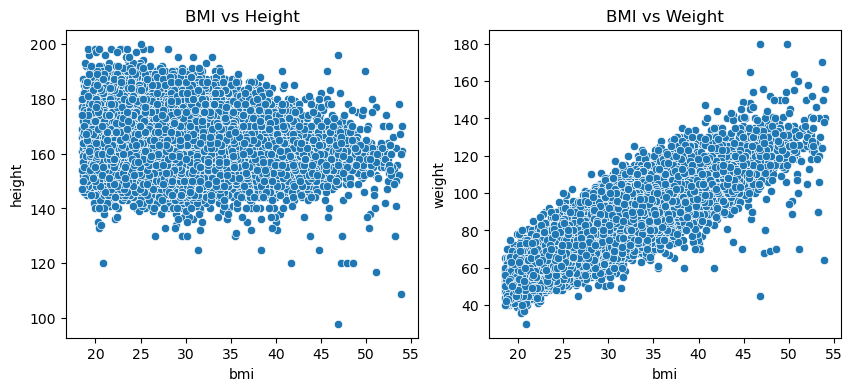

In [31]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.scatterplot(data=df,x='bmi',y='height')
plt.title('BMI vs Height')

plt.subplot(1,2,2)
sns.scatterplot(data=df,x='bmi',y='weight')
plt.title('BMI vs Weight')

There are still some small outliers where the height or weight is low and the BMI is high.<br>

Let's drop these values.<br>
Based on the scatterplot and the boxplot I will use the following values to filter:
- Weight under 60kg
- Height under 120kg
- BMI over 40

In [32]:
mask_bmiout = ((df['bmi']>40) & (df['weight']<60)) |((df['bmi']>40) &(df['height']<120))

df=df[~mask_bmiout]

Let's check the distribution again

Text(0.5, 1.0, 'BMI vs Weight after removal')

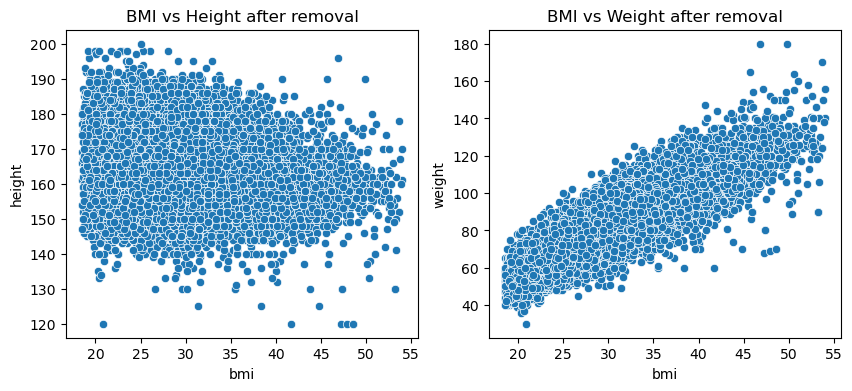

In [33]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.scatterplot(data=df,x='bmi',y='height')
plt.title('BMI vs Height after removal')

plt.subplot(1,2,2)
sns.scatterplot(data=df,x='bmi',y='weight')
plt.title('BMI vs Weight after removal')

Looks great.<br>
Let's drop the weight and height columns as this is not required anymore.

In [34]:
df = df.drop(['height','weight'],axis=1)
df.head()

,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,disease,bmi
id,,,,,,,,,,,,,,
0,2021-05-03,Indonesia,1,50,0,110,80,1,2,1,Architect,0,0,21.97
1,2021-08-05,Malaysia,1,55,0,140,90,3,1,1,Accountant,0,1,34.93
2,2022-11-13,Indonesia,0,51,0,130,70,3,1,1,Chef,0,1,23.51
3,2018-10-31,Singapore,1,48,0,150,100,1,2,1,Lawyer,0,1,28.71
4,2020-09-25,Singapore,0,47,0,100,60,1,1,1,Architect,0,0,23.01


In [35]:
## Checkpoint to save data
df_bmi = df.copy()

__ap_hi and ap_lo columns__ <a id="s13"></a><br>

Some assumptions based on the following sources:<br>
> - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2169314/
> - https://scholar.google.com/scholar_lookup?title=The+assessment+and+management+of+cardiovascular+risk&publication_year=2003&
> - https://pubmed.ncbi.nlm.nih.gov/15775768/
> - https://en.wikipedia.org/wiki/Blood_pressure
<br>

- Blood pressure end digit can be of any number, although typically rounded to the nearest 0.
- Systolic (ap_hi) feasible range is from 60 - 250
- Diastolic (ap_lo) feasible range is from 20 - 100

Lets take a look at the extreme low end of the data

In [36]:
df['ap_hi'].sort_values().head(25)

id
50055   -150
34295   -140
66571   -120
22881   -115
6525    -100
29313   -100
12494      1
60477      1
7657       7
29827     10
81051     10
41674     10
89703     10
3683      10
94673     10
82646     10
50799     11
49186     11
14598     11
69757     11
49626     11
56774     11
62937     11
9354      11
47294     11
Name: ap_hi, dtype: int64

Assumption is that any negative values are actually positive. So lets clean this up first.

In [37]:
mask_neg_aphi = df['ap_hi']<0

df_neg_aphi = df[mask_neg_aphi]
df_neg_aphi

,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,disease,bmi
id,,,,,,,,,,,,,,
6525,2020-04-05,Malaysia,1,41,0,-100,80,2,1,1,Engineer,0,0,28.65
22881,2019-04-25,Malaysia,1,60,0,-115,70,1,2,1,Others,0,0,34.72
29313,2022-07-28,Singapore,1,42,0,-100,70,1,1,1,Engineer,0,0,23.07
34295,2018-11-02,Singapore,1,50,0,-140,90,1,1,1,Architect,0,1,28.20
50055,2022-01-23,Malaysia,1,63,0,-150,80,1,2,1,Architect,0,1,20.90
66571,2021-12-27,Singapore,0,64,0,-120,80,1,2,1,Accountant,0,0,23.05


Multiply the ap_hi column with -1 to obtain a positive value

In [38]:
df_neg_aphi['ap_hi'] = df_neg_aphi['ap_hi'].multiply(-1)
df_neg_aphi

,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,disease,bmi
id,,,,,,,,,,,,,,
6525,2020-04-05,Malaysia,1,41,0,100,80,2,1,1,Engineer,0,0,28.65
22881,2019-04-25,Malaysia,1,60,0,115,70,1,2,1,Others,0,0,34.72
29313,2022-07-28,Singapore,1,42,0,100,70,1,1,1,Engineer,0,0,23.07
34295,2018-11-02,Singapore,1,50,0,140,90,1,1,1,Architect,0,1,28.20
50055,2022-01-23,Malaysia,1,63,0,150,80,1,2,1,Architect,0,1,20.90
66571,2021-12-27,Singapore,0,64,0,120,80,1,2,1,Accountant,0,0,23.05


Update the information into the main dataframe

In [39]:
df.update(df_neg_aphi)
df.reset_index().head()

,id,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,disease,bmi
0,0,2021-05-03,Indonesia,1.0,50.0,0.0,110.0,80.0,1.0,2,1.0,Architect,0.0,0.0,21.97
1,1,2021-08-05,Malaysia,1.0,55.0,0.0,140.0,90.0,3.0,1,1.0,Accountant,0.0,1.0,34.93
2,2,2022-11-13,Indonesia,0.0,51.0,0.0,130.0,70.0,3.0,1,1.0,Chef,0.0,1.0,23.51
3,3,2018-10-31,Singapore,1.0,48.0,0.0,150.0,100.0,1.0,2,1.0,Lawyer,0.0,1.0,28.71
4,4,2020-09-25,Singapore,0.0,47.0,0.0,100.0,60.0,1.0,1,1.0,Architect,0.0,0.0,23.01


Check if the data is updated

In [40]:
negaphi_index = list(df_neg_aphi.index.values) 
df.iloc[negaphi_index]

,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,disease,bmi
id,,,,,,,,,,,,,,
9412,2022-06-16,Malaysia,1.0,46.0,0.0,130.0,80.0,1.0,1,1.0,Architect,0.0,0.0,35.38
33027,2021-03-20,Singapore,1.0,60.0,0.0,180.0,100.0,3.0,1,1.0,Engineer,0.0,1.0,28.44
42354,2018-01-11,Singapore,1.0,58.0,0.0,120.0,70.0,1.0,1,1.0,Engineer,0.0,0.0,22.19
49525,2020-05-14,India,1.0,59.0,0.0,154.0,87.0,1.0,2,1.0,Lawyer,0.0,1.0,32.95
72232,2018-10-07,Indonesia,0.0,53.0,0.0,120.0,80.0,1.0,1,1.0,Lawyer,0.0,1.0,33.25
96149,2020-10-22,Singapore,1.0,45.0,1.0,130.0,90.0,2.0,1,1.0,Teacher,0.0,1.0,33.59


Check if there are any similar negative values in ap_lo

In [41]:
df['ap_lo'].sort_values(ascending=True).head(25)

id
85816   -70.0
19258     0.0
93224     0.0
36325     0.0
57646     0.0
45400     0.0
75007     0.0
23512     0.0
24837     0.0
81298     0.0
32749     0.0
65470     0.0
68612     0.0
39577     0.0
34120     0.0
62754     0.0
60565     0.0
91073     0.0
2845      0.0
54780     0.0
50210     1.0
40122     6.0
97950     6.0
26983     7.0
27242     7.0
Name: ap_lo, dtype: float64

There seems to be only one, multiply this value by -1 to get positive

In [42]:
df['ap_lo']=np.where(df['ap_lo'] <0,df['ap_lo']*-1,df['ap_lo'])
df['ap_lo'].sort_values(ascending=True).head(25) #check if value is updated

id
75007    0.0
57646    0.0
36325    0.0
93224    0.0
2845     0.0
68612    0.0
81298    0.0
65470    0.0
32749    0.0
45400    0.0
34120    0.0
39577    0.0
24837    0.0
54780    0.0
23512    0.0
62754    0.0
60565    0.0
19258    0.0
91073    0.0
50210    1.0
40122    6.0
97950    6.0
27242    7.0
26983    7.0
13943    8.0
Name: ap_lo, dtype: float64

Let's tackle the out of range blood pressure values.

as a reminder :
- Systolic (ap_hi) feasible range is from 60 - 250
- Diastolic (ap_lo) feasible range is from 20 - 100

<br>
Let's start by cleaning the ap_hi ranges

In [43]:
aphi_range = (df['ap_hi']<251) & (df['ap_hi']>59)

df[aphi_range].sort_values(by='ap_hi',ascending=True).head()


,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,disease,bmi
id,,,,,,,,,,,,,,
19634,2018-12-04,Singapore,0.0,43.0,0.0,60.0,40.0,1.0,1,3.0,Teacher,0.0,0.0,29.62
46733,2018-11-22,Indonesia,0.0,57.0,0.0,70.0,100.0,1.0,2,1.0,Engineer,0.0,0.0,26.03
47851,2019-03-11,India,1.0,42.0,1.0,70.0,110.0,1.0,1,1.0,Accountant,0.0,0.0,23.60
57807,2022-07-22,India,0.0,56.0,0.0,70.0,1100.0,1.0,1,1.0,Doctor,0.0,0.0,23.05
58065,2021-02-04,India,1.0,46.0,1.0,70.0,120.0,1.0,2,1.0,Doctor,1.0,0.0,25.99


In [44]:
df[aphi_range].sort_values(by='ap_hi',ascending=False).head()

,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,disease,bmi
id,,,,,,,,,,,,,,
46495,2022-06-12,India,1.0,58.0,0.0,240.0,110.0,1.0,2,1.0,Doctor,1.0,1.0,31.64
99019,2022-02-20,India,0.0,54.0,0.0,240.0,130.0,1.0,1,1.0,Nurse,0.0,1.0,29.49
79903,2022-10-27,Indonesia,1.0,60.0,0.0,240.0,110.0,1.0,2,1.0,Lawyer,0.0,0.0,37.13
37198,2021-09-20,Singapore,1.0,61.0,0.0,240.0,130.0,2.0,1,1.0,Teacher,0.0,1.0,37.02
42394,2018-06-11,India,1.0,54.0,1.0,240.0,120.0,2.0,2,1.0,Engineer,0.0,1.0,24.77


Looks correct, let's apply this to our main dataframe

In [45]:
df = df[aphi_range]

Next let's clean the ap_lo values

In [46]:
aplo_range = (df['ap_lo']<101) & (df['ap_lo']>19)

df[aplo_range].sort_values(by='ap_lo',ascending=True).head()

,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,disease,bmi
id,,,,,,,,,,,,,,
58088,2020-03-27,Malaysia,1.0,40.0,0.0,120.0,20.0,1.0,1,1.0,Teacher,0.0,0.0,22.10
57023,2021-07-03,Malaysia,1.0,49.0,0.0,120.0,20.0,2.0,1,2.0,Architect,0.0,1.0,18.83
58537,2022-05-07,India,1.0,52.0,0.0,100.0,20.0,1.0,1,1.0,Architect,0.0,0.0,23.53
33295,2022-10-05,India,0.0,45.0,0.0,120.0,20.0,1.0,2,1.0,Nurse,0.0,0.0,22.31
19885,2020-05-23,Singapore,1.0,49.0,0.0,110.0,20.0,1.0,1,1.0,Engineer,0.0,0.0,27.51


In [47]:
df[aplo_range].sort_values(by='ap_lo',ascending=False).head()

,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,disease,bmi
id,,,,,,,,,,,,,,
17984,2018-01-15,Indonesia,1.0,63.0,0.0,160.0,100.0,1.0,1,1.0,Teacher,0.0,1.0,26.38
58996,2020-06-24,Malaysia,0.0,59.0,0.0,163.0,100.0,3.0,2,3.0,Architect,1.0,1.0,36.75
45489,2022-04-01,Malaysia,1.0,64.0,0.0,160.0,100.0,1.0,2,1.0,Accountant,0.0,1.0,30.41
45495,2020-04-06,Indonesia,1.0,50.0,0.0,180.0,100.0,3.0,2,1.0,Chef,0.0,1.0,28.34
45496,2019-09-27,Indonesia,1.0,51.0,0.0,150.0,100.0,3.0,1,1.0,Engineer,0.0,1.0,26.93


Looks great! Let's apply the mask to our main dataframe.

In [48]:
df = df[aplo_range]

Another logic is that systolic bp is always higher than diastolic bp, lets make a boolean mask for where this is false <br>
and make a new dataframe

In [49]:
mask_low_aphi_vs_aplo = df['ap_hi'] < df['ap_lo']

df_low_aphi_vs_aplo = df[mask_low_aphi_vs_aplo]
print(len(df_low_aphi_vs_aplo))
df_low_aphi_vs_aplo

6


,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,disease,bmi
id,,,,,,,,,,,,,,
6843,2019-01-23,India,0.0,46.0,0.0,70.0,100.0,1.0,2,1.0,Engineer,0.0,0.0,26.90
14119,2020-02-13,Indonesia,1.0,53.0,0.0,85.0,95.0,1.0,1,1.0,Nurse,0.0,0.0,31.04
32702,2018-12-02,India,0.0,56.0,1.0,95.0,100.0,1.0,2,1.0,Chef,0.0,1.0,26.51
46733,2018-11-22,Indonesia,0.0,57.0,0.0,70.0,100.0,1.0,2,1.0,Engineer,0.0,0.0,26.03
66423,2019-10-24,Indonesia,1.0,41.0,0.0,90.0,100.0,1.0,2,1.0,Teacher,1.0,0.0,29.04
71012,2020-05-05,Singapore,0.0,64.0,0.0,80.0,100.0,1.0,1,1.0,Lawyer,0.0,1.0,24.77


There are 6 entries where this is true. Let's drop these rows.

In [50]:
df = df[~mask_low_aphi_vs_aplo]

Apply the mask and check if all rows have been removed

In [51]:
df[mask_low_aphi_vs_aplo]

C:\Users\nexa_\AppData\Local\Temp\ipykernel_8928\2198032879.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[mask_low_aphi_vs_aplo]


,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,disease,bmi
id,,,,,,,,,,,,,,


Nothing returned so all data has been cleared.<br>
Will look at the data distribution again.

Text(0.5, 1.0, 'Data distribution of ap_hi and ap_lo')

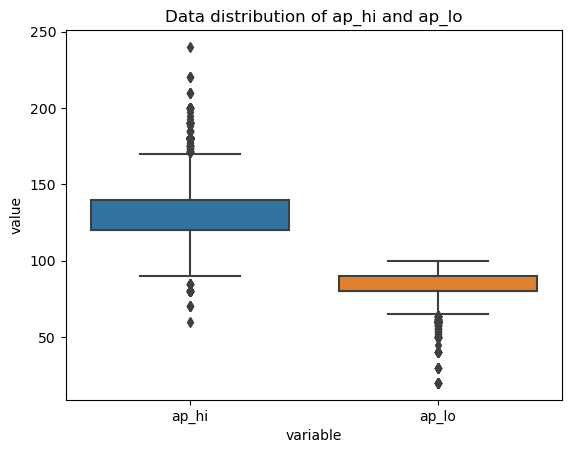

In [52]:
bp_comb = df.loc[:,['ap_hi','ap_lo']]
sns.boxplot(x='variable', y='value',data=bp_comb.melt())
plt.title("Data distribution of ap_hi and ap_lo")

In [53]:
## Checkpoint 3
df_allapclean = df

### Convert columns with strings to boolean numericals <a id="s14"></a>
__Country column__<a id="s15"></a><br>
Lets check what unique values are in country column

In [54]:
df['country'].unique()

array(['Indonesia', 'Malaysia', 'Singapore', 'India'], dtype=object)

There are only 4 countries listed as follows (in alphabetical order) with their assigned numerical categories
- India
- Indonesia
- Malaysia
- Singapore

Lets create dummy variables for the country column

In [55]:
country_dummy = pd.get_dummies(df['country'], prefix='C')


Concatenate the new columns into our main dataframe

In [56]:
df = pd.concat([df,country_dummy],axis=1)
df.head()

,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,disease,bmi,C_India,C_Indonesia,C_Malaysia,C_Singapore
id,,,,,,,,,,,,,,,,,,
0,2021-05-03,Indonesia,1.0,50.0,0.0,110.0,80.0,1.0,2,1.0,Architect,0.0,0.0,21.97,0,1,0,0
1,2021-08-05,Malaysia,1.0,55.0,0.0,140.0,90.0,3.0,1,1.0,Accountant,0.0,1.0,34.93,0,0,1,0
2,2022-11-13,Indonesia,0.0,51.0,0.0,130.0,70.0,3.0,1,1.0,Chef,0.0,1.0,23.51,0,1,0,0
3,2018-10-31,Singapore,1.0,48.0,0.0,150.0,100.0,1.0,2,1.0,Lawyer,0.0,1.0,28.71,0,0,0,1
4,2020-09-25,Singapore,0.0,47.0,0.0,100.0,60.0,1.0,1,1.0,Architect,0.0,0.0,23.01,0,0,0,1


Drop the country column as we do not need it anymore

In [57]:
df.drop('country', axis=1, inplace=True)
df.head()

,date,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,disease,bmi,C_India,C_Indonesia,C_Malaysia,C_Singapore
id,,,,,,,,,,,,,,,,,
0,2021-05-03,1.0,50.0,0.0,110.0,80.0,1.0,2,1.0,Architect,0.0,0.0,21.97,0,1,0,0
1,2021-08-05,1.0,55.0,0.0,140.0,90.0,3.0,1,1.0,Accountant,0.0,1.0,34.93,0,0,1,0
2,2022-11-13,0.0,51.0,0.0,130.0,70.0,3.0,1,1.0,Chef,0.0,1.0,23.51,0,1,0,0
3,2018-10-31,1.0,48.0,0.0,150.0,100.0,1.0,2,1.0,Lawyer,0.0,1.0,28.71,0,0,0,1
4,2020-09-25,0.0,47.0,0.0,100.0,60.0,1.0,1,1.0,Architect,0.0,0.0,23.01,0,0,0,1


__Occupation column__ <a id="s16"></a>

In [58]:
df['occupation'].unique()

array(['Architect', 'Accountant', 'Chef', 'Lawyer', 'Teacher', 'Nurse',
       'Engineer', 'Doctor', 'Others'], dtype=object)

In [59]:
df['occupation'].value_counts()

Nurse         7638
Architect     7560
Accountant    7542
Others        7529
Lawyer        7430
Chef          7411
Doctor        7391
Teacher       7371
Engineer      7369
Name: occupation, dtype: int64

The occupation category does not have a general sampling, and I am not sure if this will help our data. Will drop this column.

In [60]:
df = df.drop(['occupation'],axis=1)
df.head()

,date,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,smoke,disease,bmi,C_India,C_Indonesia,C_Malaysia,C_Singapore
id,,,,,,,,,,,,,,,,
0,2021-05-03,1.0,50.0,0.0,110.0,80.0,1.0,2,1.0,0.0,0.0,21.97,0,1,0,0
1,2021-08-05,1.0,55.0,0.0,140.0,90.0,3.0,1,1.0,0.0,1.0,34.93,0,0,1,0
2,2022-11-13,0.0,51.0,0.0,130.0,70.0,3.0,1,1.0,0.0,1.0,23.51,0,1,0,0
3,2018-10-31,1.0,48.0,0.0,150.0,100.0,1.0,2,1.0,0.0,1.0,28.71,0,0,0,1
4,2020-09-25,0.0,47.0,0.0,100.0,60.0,1.0,1,1.0,0.0,0.0,23.01,0,0,0,1


### Date Column <a id="s17"></a>
We do not need the date column, so will drop it

In [61]:
df = df.drop(['date'],axis=1)
df.head()

,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,smoke,disease,bmi,C_India,C_Indonesia,C_Malaysia,C_Singapore
id,,,,,,,,,,,,,,,
0,1.0,50.0,0.0,110.0,80.0,1.0,2,1.0,0.0,0.0,21.97,0,1,0,0
1,1.0,55.0,0.0,140.0,90.0,3.0,1,1.0,0.0,1.0,34.93,0,0,1,0
2,0.0,51.0,0.0,130.0,70.0,3.0,1,1.0,0.0,1.0,23.51,0,1,0,0
3,1.0,48.0,0.0,150.0,100.0,1.0,2,1.0,0.0,1.0,28.71,0,0,0,1
4,0.0,47.0,0.0,100.0,60.0,1.0,1,1.0,0.0,0.0,23.01,0,0,0,1


## Final Touchups <a id="s18"></a>
Lets convert any categorical columns that are in float dtype to uint8 as this uses less memory, ap_hi and ap_lo do not have decimals, so will convert them to int.

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67241 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   active       67241 non-null  float64
 1   age          67241 non-null  float64
 2   alco         67241 non-null  float64
 3   ap_hi        67241 non-null  float64
 4   ap_lo        67241 non-null  float64
 5   cholesterol  67241 non-null  float64
 6   gender       67241 non-null  object 
 7   gluc         67241 non-null  float64
 8   smoke        67241 non-null  float64
 9   disease      67241 non-null  float64
 10  bmi          67241 non-null  float64
 11  C_India      67241 non-null  uint8  
 12  C_Indonesia  67241 non-null  uint8  
 13  C_Malaysia   67241 non-null  uint8  
 14  C_Singapore  67241 non-null  uint8  
dtypes: float64(10), object(1), uint8(4)
memory usage: 6.4+ MB


In [64]:
df['age']=df['age'].astype(np.uint8)
df['active']=df['active'].astype(np.uint8)
df['alco']=df['alco'].astype(np.uint8)
df['ap_hi']=df['ap_hi'].astype(int)
df['ap_lo']=df['ap_lo'].astype(int)
df['cholesterol']=df['cholesterol'].astype(np.uint8)
df['gender']=df['gender'].astype(np.uint8)
df['gluc']=df['gluc'].astype(np.uint8)
df['smoke']=df['smoke'].astype(np.uint8)
df['disease']=df['disease'].astype(np.uint8)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67241 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   active       67241 non-null  uint8  
 1   age          67241 non-null  uint8  
 2   alco         67241 non-null  uint8  
 3   ap_hi        67241 non-null  int32  
 4   ap_lo        67241 non-null  int32  
 5   cholesterol  67241 non-null  uint8  
 6   gender       67241 non-null  uint8  
 7   gluc         67241 non-null  uint8  
 8   smoke        67241 non-null  uint8  
 9   disease      67241 non-null  uint8  
 10  bmi          67241 non-null  float64
 11  C_India      67241 non-null  uint8  
 12  C_Indonesia  67241 non-null  uint8  
 13  C_Malaysia   67241 non-null  uint8  
 14  C_Singapore  67241 non-null  uint8  
dtypes: float64(1), int32(2), uint8(12)
memory usage: 2.3 MB


In [65]:
# checkpoint 4
df_cleanall = df.copy()

In [66]:
df.describe()

,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,smoke,disease,bmi,C_India,C_Indonesia,C_Malaysia,C_Singapore
count,67241.000000,67241.000000,67241.000000,67241.000000,67241.000000,67241.000000,67241.000000,67241.000000,67241.000000,67241.000000,67241.000000,67241.000000,67241.000000,67241.000000,67241.000000
mean,0.802948,52.840573,0.052974,126.323151,81.012983,1.362799,1.348180,1.225294,0.087372,0.493122,27.469126,0.248569,0.249684,0.249357,0.252391
std,0.397775,6.764790,0.223983,16.003657,8.893059,0.677642,0.476397,0.571716,0.282382,0.499956,5.019623,0.432186,0.432833,0.432644,0.434387
min,0.000000,29.000000,0.000000,60.000000,20.000000,1.000000,1.000000,1.000000,0.000000,0.000000,18.500000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,48.000000,0.000000,120.000000,80.000000,1.000000,1.000000,1.000000,0.000000,0.000000,23.880000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,53.000000,0.000000,120.000000,80.000000,1.000000,1.000000,1.000000,0.000000,0.000000,26.370000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,58.000000,0.000000,140.000000,90.000000,1.000000,2.000000,1.000000,0.000000,1.000000,30.120000,0.000000,0.000000,0.000000,1.000000
max,1.000000,64.000000,1.000000,240.000000,100.000000,3.000000,2.000000,3.000000,1.000000,1.000000,54.010000,1.000000,1.000000,1.000000,1.000000


In [67]:
def perct(x,y):
    return (1-(x/y))
    

print("Number of entries in cleaned data",len(df))
print("Number of entries in original data",len(og_df))
print('{:.2%} of the data have been removed'.format(perct(len(df),len(og_df))))

Number of entries in cleaned data 67241
Number of entries in original data 70000
3.94% of the data have been removed


## Export Data <a id="s19"></a>
Write the data back into Postgresql as a new table

In [68]:
df.to_sql(name='cardio_clean', con=engine, if_exists = 'append', index=False, chunksize=200)

67241